In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam


#jax.config.update("jax_enable_x64", True)


#import chainconsumer as cc
# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from newfisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
jax.__version__

'0.6.2'

In [4]:
wid = 80
oversample = 4

nwavels = 20
npoly=5
nzernikes = 12

psf_oversample = 4

optics = NICMOSOptics(512, wid, oversample, n_zernikes=nzernikes)
oversampled_optics = NICMOSOptics(512, wid, oversample*psf_oversample, psf_oversample=psf_oversample, n_zernikes=nzernikes)


detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]
exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_38763/3041937632.py:26: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]
/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_38763/3041937632.py:27: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]


In [5]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
          -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
           7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8., 8.])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample

model_normal = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_oversampled = set_array(NICMOSModel(exposures_single, params, oversampled_optics, detector))

model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

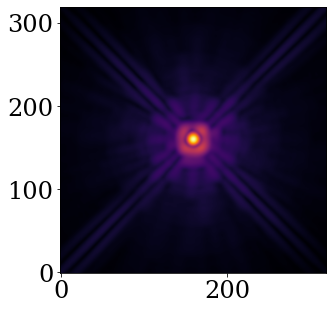

In [6]:
# generate oversampled PSF
psf = exposures_single[0].fit(model_oversampled,exposures_single[0])
plt.imshow(psf**0.25)

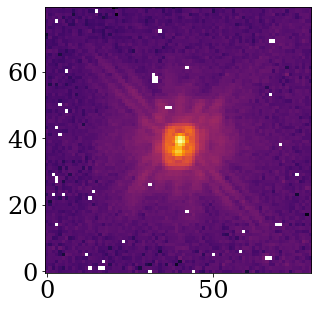

In [7]:
plt.imshow(exposures_single[0].data**0.125)

In [8]:
# Shrish's FFT shifting code
fft, ifft, fftshift = np.fft.fft2, np.fft.ifft2, np.fft.fftshift
rfft, irfft, rfftfreq = np.fft.rfft2, np.fft.irfft2, np.fft.rfftfreq

def reposition(image,dx,dy):
    '''
    Shift an image by dx, dy pixels using FFT

    Parameters
    ----------
    image : ndarray
        2D image to be shifted
    dx : float
        shift in x direction
    dy : float
        shift in y direction
    
    Returns
    -------
    shifted_image : ndarray
        2D image shifted by dx, dy
    
    '''

    # Get the shape of the image
    Nx, Ny = image.shape

    # Create the frequency grid
    kx = fftshift(np.fft.fftfreq(Nx, d=1.))
    ky = fftshift(np.fft.fftfreq(Ny, d=1.))

    # Create the phase ramp
    phase_ramp = np.exp(-2.j*np.pi*(kx[:,None]*dx + ky[None,:]*dy))

    # Shift the image in Fourier space
    shifted_image = fftshift(ifft(fft(fftshift(image))*fftshift(phase_ramp)))

    return np.abs(shifted_image) 

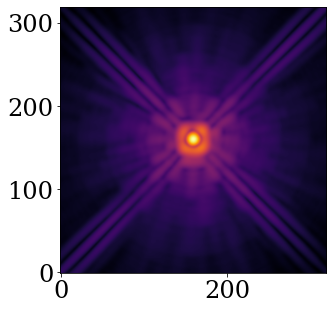

In [9]:
plt.imshow(reposition(psf, 0, 0)**0.125)

In [10]:
def fit_flux(exp, template):

    psf = template.flatten()

    bad = exp.bad.flatten()
    err = exp.err.flatten()

    psf= np.where(exp.bad.flatten(), 0., psf)

    psf = psf/np.sum(psf)

    data = exp.data.flatten()
        #data= data.at[exp.bad.flatten()].set(0.)
    data= np.where(exp.bad.flatten(), 0., data)


    design = np.transpose(np.vstack((np.ones(len(psf)), psf)))

    flux_raw, _, _, _ = np.linalg.lstsq(design, data)
    true_flux = flux_raw[1]        
    #true_flux= np.log10(flux_raw[1]/nwavels * 2/(1+contrast)) - spec
        #print(true_flux)
    
    return -np.sum(np.where(bad, 0., jsp.stats.norm.logpdf(psf*true_flux, data, err))), true_flux#loss(template*true_flux, exp)

In [11]:
@zdx.filter_jit
def grid_loss_single(dx, dy):
    psf_shifted = dlu.downsample(reposition(psf, dx*psf_oversample,dy*psf_oversample), psf_oversample)
    return fit_flux(exposures_single[0], psf_shifted)[0]

In [12]:
Nx, Ny = 50, 50

xs = np.linspace(-5, 5, Nx)
ys = np.linspace(-5, 5, Ny)

losses = np.zeros((Nx, Ny))

for i, dx in enumerate(xs):
    for j, dy in enumerate(ys):
        #print(grid_loss(dx,dy))
        losses = losses.at[i,j].set(grid_loss_single(dx,dy))
        #psf_shifted = dlu.downsample(reposition(psf, dx*psf_oversample,dy*psf_oversample), psf_oversample)
        #losses = losses.at[i,j].set(fit_flux(exposures_single[0], psf_shifted))

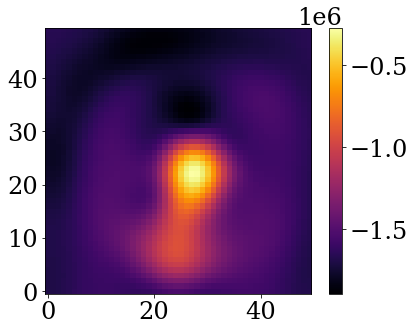

In [13]:
plt.imshow(-np.asarray(losses))
plt.colorbar()

In [14]:
xi, yi = np.unravel_index(losses.argmin(), losses.shape)
xp, yp = xs[xi], ys[yi]
print(xp, yp)

-0.5102041 0.51020384


In [15]:
@zdx.filter_jit
def grid_loss_binary(dx1, dy1, r, theta, contrast, return_flux = False, return_psf = False):
    ang = dlu.deg2rad(theta)
    dx2 = dx1-r*np.cos(ang)
    dy2 = dy1-r*np.sin(ang)
    #dx1 = dx1+r*np.sin(ang)/2
    #dy1 = dy1+r*np.cos(ang)/2
    primary_shifted = reposition(psf, dx1*psf_oversample,dy1*psf_oversample)
    secondary_shifted = reposition(psf, dx2*psf_oversample,dy2*psf_oversample)
    f1, f2 = dlu.fluxes_from_contrast(1, contrast)
    psf_total = dlu.downsample(f1*primary_shifted + f2*secondary_shifted, psf_oversample)
    if return_psf:
        return psf_total
    if return_flux:
        return fit_flux(exposures_single[0], psf_total)
    return fit_flux(exposures_single[0], psf_total)[0]

In [16]:
Nx, Ny, Nc = 20, 50, 20

rs = np.linspace(0, 5, Nx)
thetas = np.linspace(-180, 180, Ny)
cs = 10**(np.linspace(0, 1, Nc))


losses = np.zeros((Nx, Ny, Nc))

for i, r in enumerate(rs):
    for j, theta in enumerate(thetas):
        for k, c in enumerate(cs):
            losses = losses.at[i,j, k].set(grid_loss_binary(xp,yp, r, theta, c))

In [17]:
ri, ti, ci = np.unravel_index(losses.argmin(), losses.shape)
rs, ts, cont = rs[ri], thetas[ti], cs[ci]
print(rs, ts, cont)

3.1578948 11.020402 2.9763515


In [18]:
best_flux = grid_loss_binary(xp,yp, rs, ts, cont, return_flux=True)[1]
true_best_flux = true_flux= np.log10(best_flux/nwavels * 2/(1+cont)) - np.log10(np.nansum(exp.data)/nwavels)

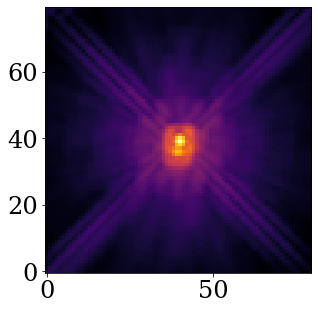

In [19]:
plt.imshow(grid_loss_binary(xp,yp, rs, ts, cont, return_psf=True)**0.125)

In [20]:
#stop

In [21]:
def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    ang = dlu.deg2rad(theta)

    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = dlu.list2dictionary([(exp.fit.get_key(exp, "positions"), np.array([y-r*np.sin(ang)/2,x-r*np.cos(ang)/2])) for exp in exposures], ordered=True)#np.array([x,y])
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta#-theta+90 #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)

In [22]:
binary_params = extract_binary_params(params, exposures_binary, xp, yp, ts, rs, true_best_flux, cont)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [23]:
binary_params.params

{'positions': OrderedDict([('n8yj59glq',
               Array([ 0.20837456, -2.0600343 ], dtype=float32))]),
 'spectrum': {'U20081_F110W': Array([2.3799665, 0.       , 0.       , 0.       , 0.       ], dtype=float32)},
 'aberrations': {'n8yj59glq': Array([  0.        ,  24.884588  , -25.489779  , -17.15699   ,
         -21.790146  ,  -4.592212  ,  -4.832893  ,  19.196083  ,
           0.37983412,   7.0756216 ,   0.30277824,  -6.330534  ],      dtype=float32)},
 'cold_mask_shift': {'53255': Array([8., 8.], dtype=float32)},
 'cold_mask_rot': {'global': -45.0},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_rot': {'F110W': 45.0},
 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'outer_radius': 1.146,
 'secondary_radius': 0.44639999999999996,
 'spider_width': 0.0924,
 'scale': 0.0432,
 'softening': 2.0,
 'bias': {'n8yj59glq': 0.0

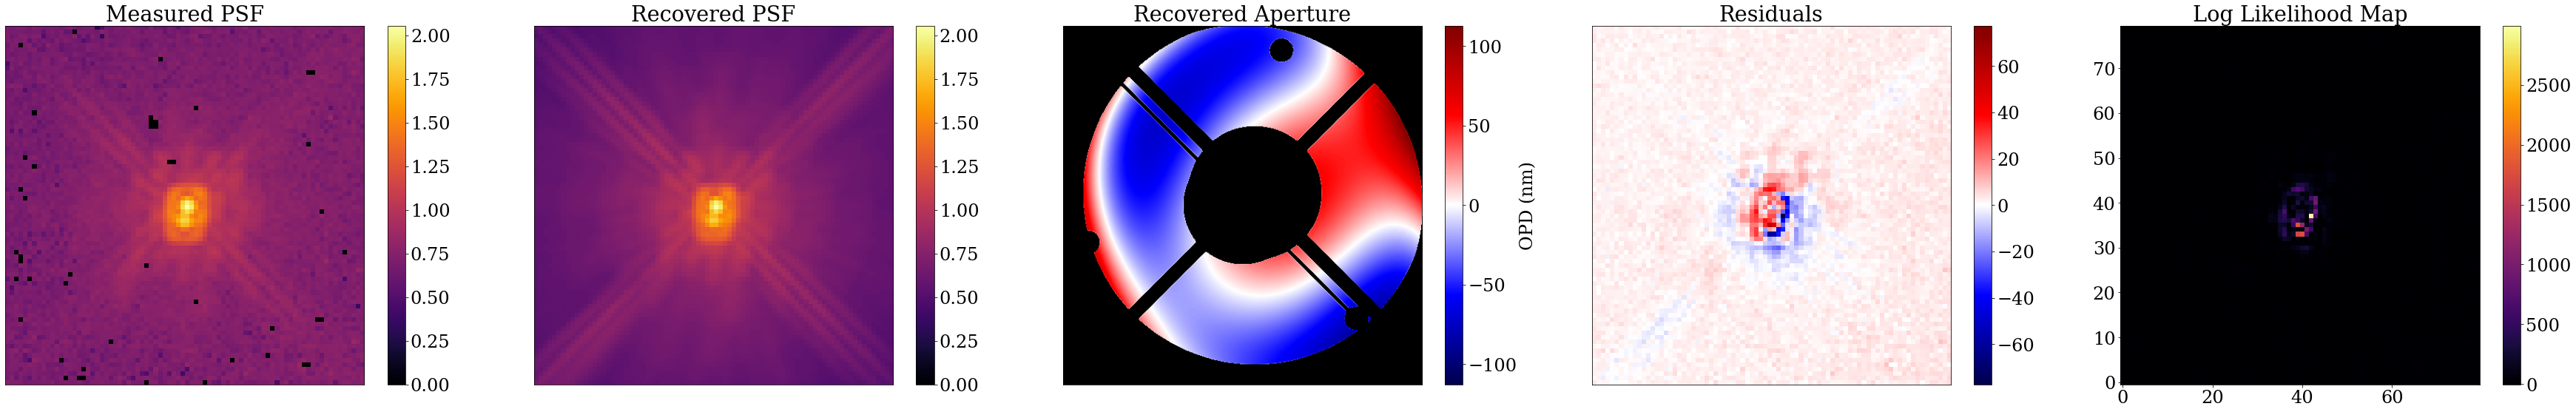

In [24]:
plot_comparison(model_binary, binary_params, exposures_binary)

In [25]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_lbfgs = lambda vals: optax.lbfgs(vals)

optl = lambda lr, start, *schedule: base_lbfgs(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 3e-2

things = {
    "positions": opt(g*5, 0),
    #"spectrum": opt(g*8, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*10, 20),
    #"cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*3, 20),
    "aberrations": opta(2, 60),

    "separation": opt(g*10, 0),
    "position_angle": opt(g*10, 10),
    "primary_spectrum": opt(g*2, 30),
    "secondary_spectrum": opt(g*0.2, 40),#, (20, 1.5)),
}


groups = list(things.keys())

In [26]:
losses, models = optimise(params, model_binary, exposures_binary, things, 300)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

ModelParams(
  params={
    'positions': {'n8yj59glq': f32[2]},
    'spectrum': {'U20081_F110W': f32[5]},
    'aberrations': {'n8yj59glq': f32[12]},
    'cold_mask_shift': {'53255': f32[2]},
    'cold_mask_rot': {'global': -45.0},
    'cold_mask_scale': {'F110W': f32[2]},
    'cold_mask_shear': {'F110W': f32[2]},
    'primary_scale': {'F110W': f32[2]},
    'primary_rot': {'F110W': 45.0},
    'primary_shear': {'F110W': f32[2]},
    'outer_radius': 1.146,
    'secondary_radius': 0.44639999999999996,
    'spider_width': 0.0924,
    'scale': 0.0432,
    'softening': 2.0,
    'bias': {'n8yj59glq': 0.0},
    'jitter': {'n8yj59glq': 0.6511627906976745}
  }
)
Fitting Model


  0%|          | 0/300 [00:00<?, ?it/s]

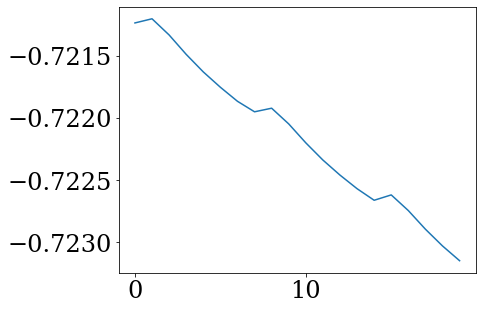

In [27]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_binary)*wid**2))

8


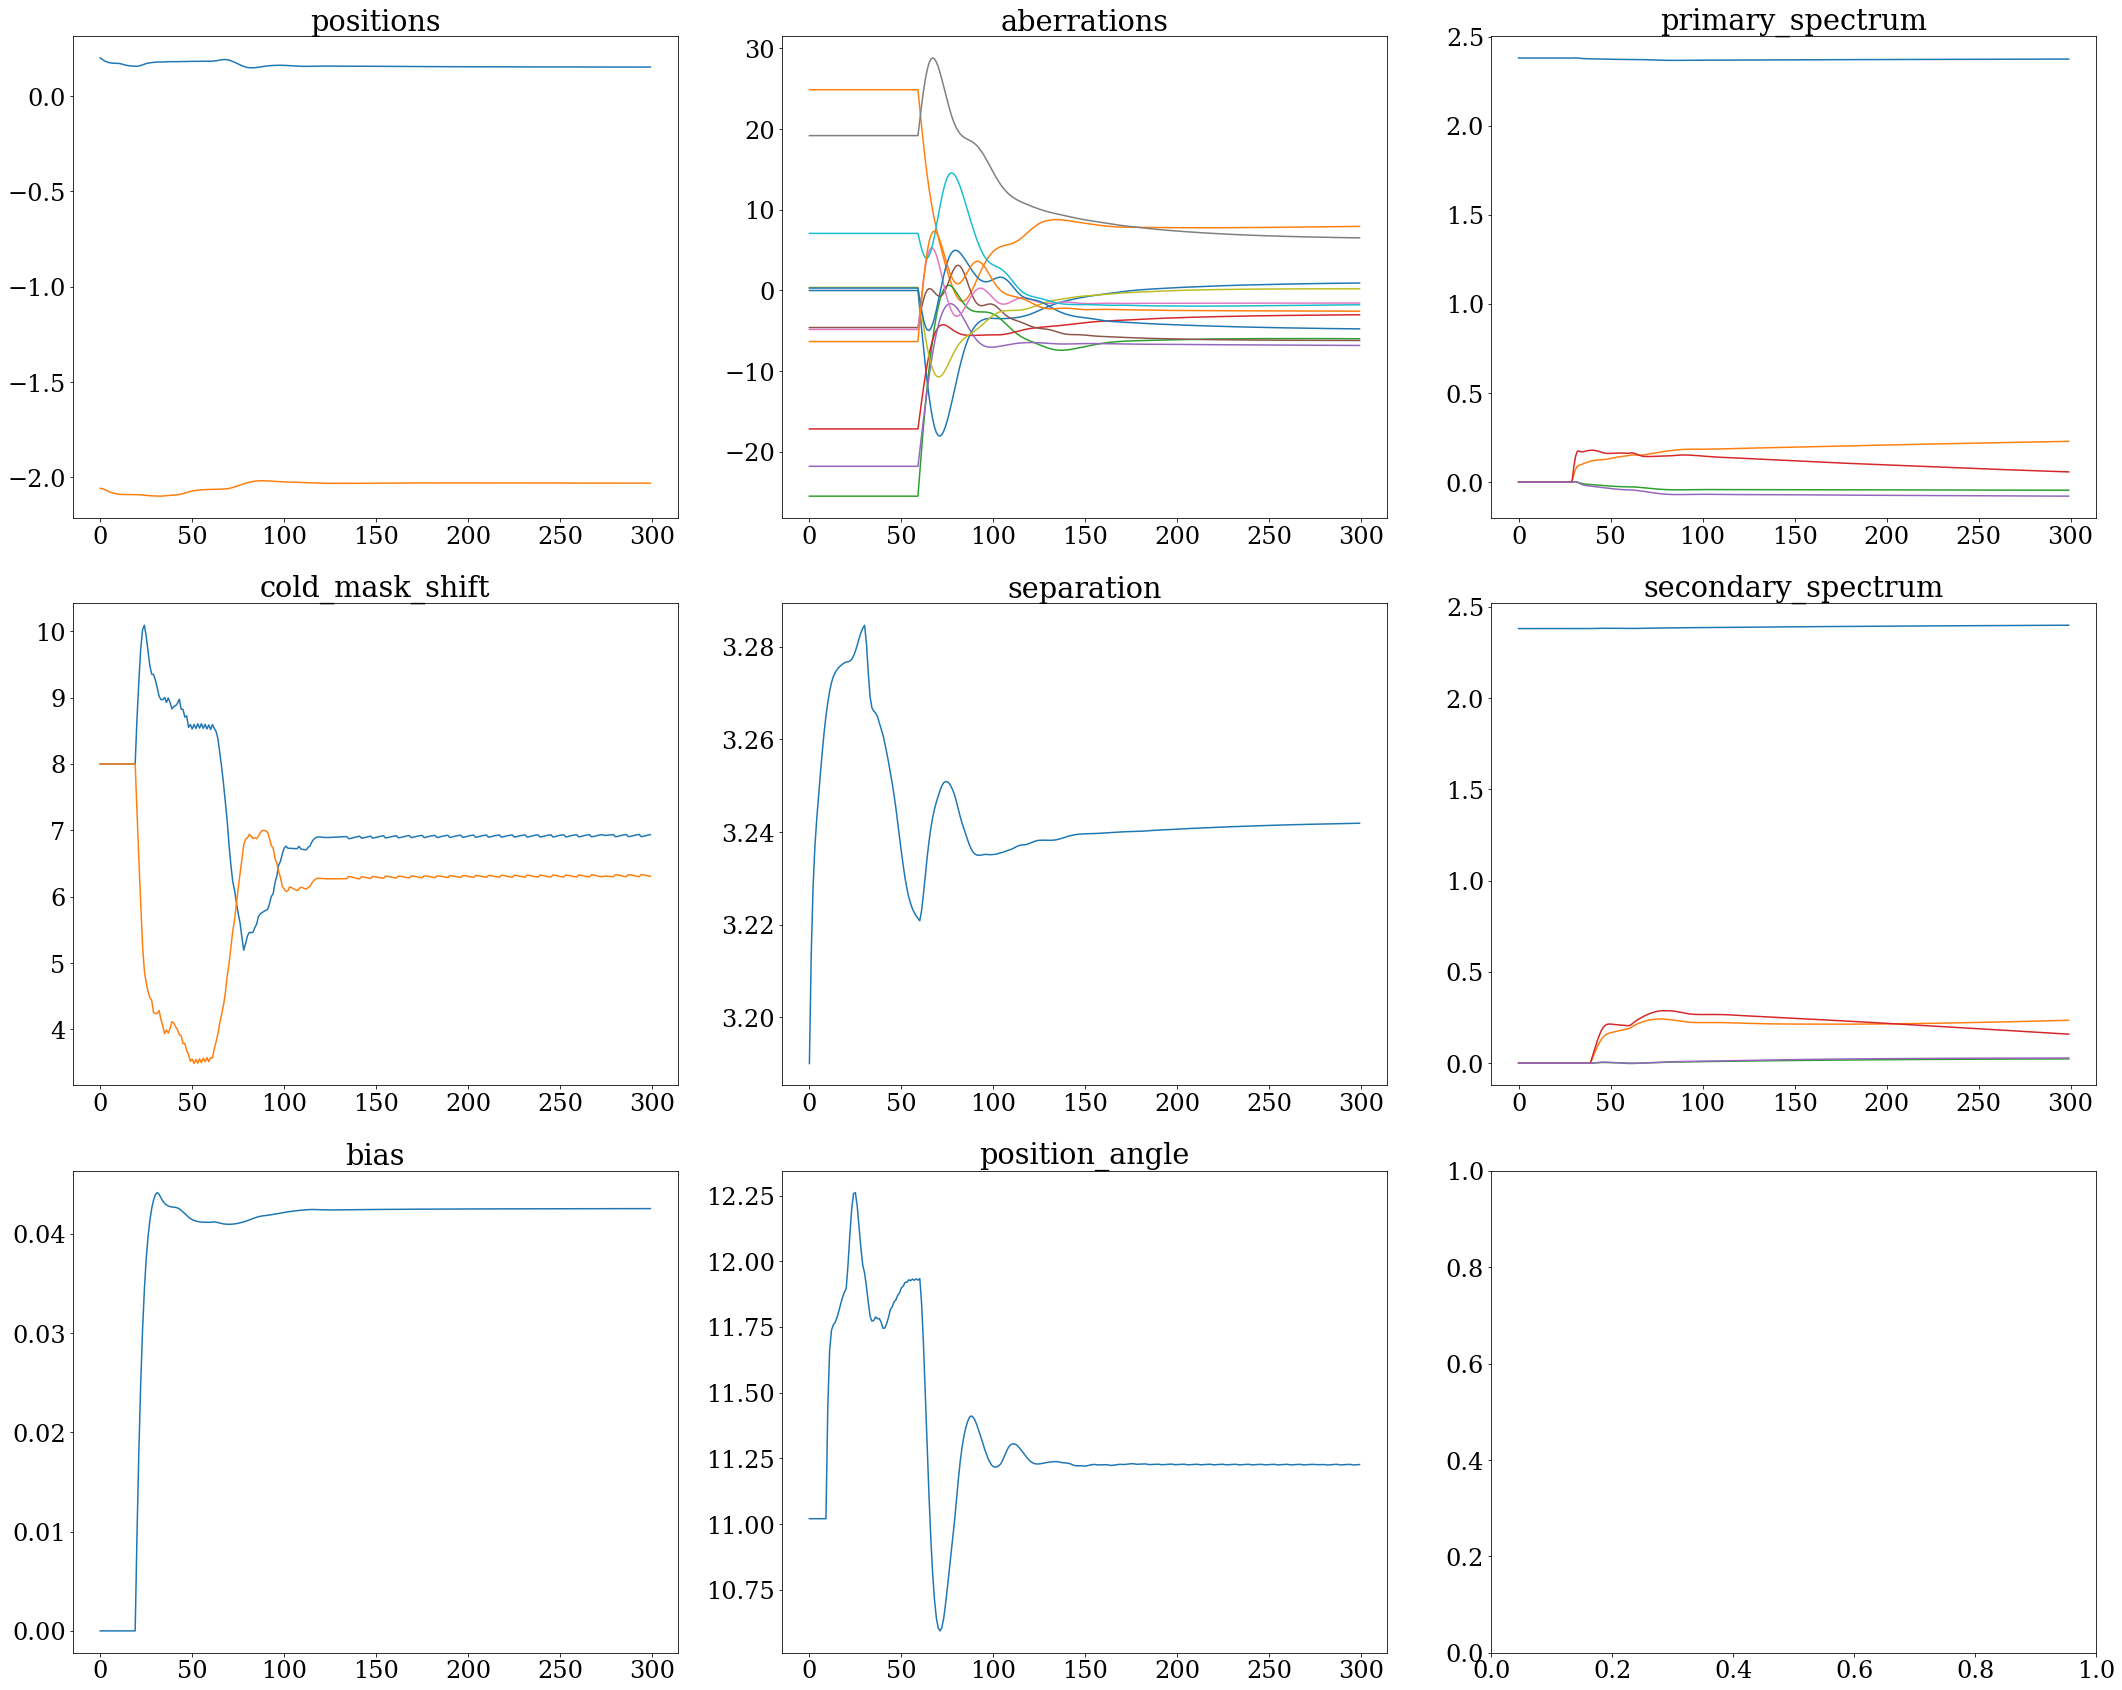

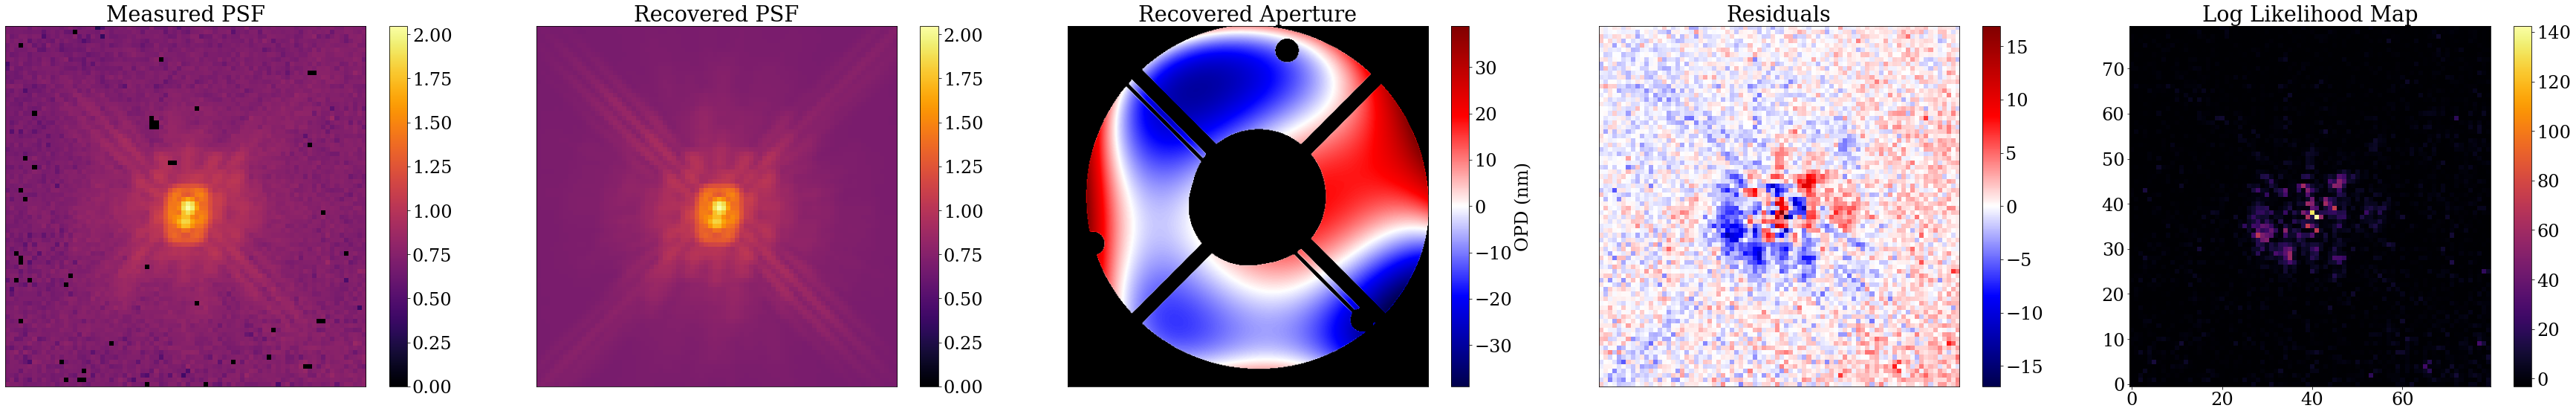

In [28]:
plot_params(models, groups, xw = 3)
plot_comparison(model_binary, models[-1], exposures_binary)

Text(0, 0.5, 'Relative Spectral Intensity')

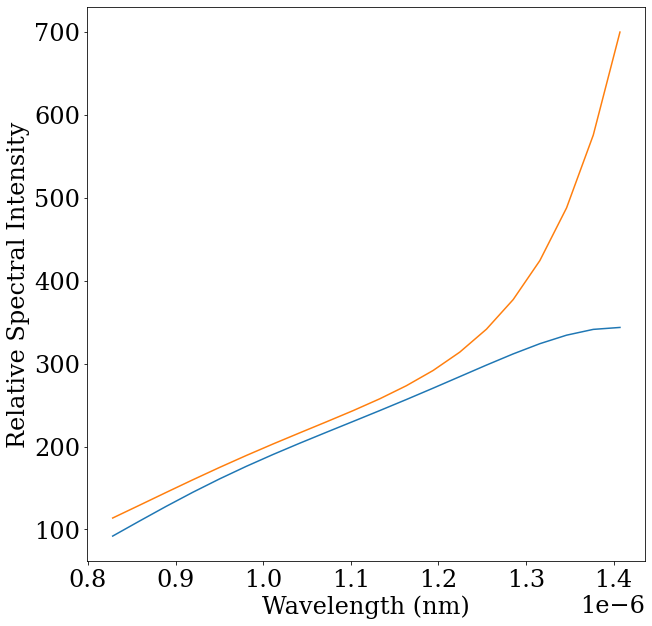

In [29]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [30]:
fishers = calc_fishers(models[-1].inject(model_binary), exposures_binary, groups, fisher_fn, recalculate=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
fishers

{'n8yj59glq.positions': Array([[1890996.9 ,  -67902.08],
        [ -67902.06, 1649645.2 ]], dtype=float32),
 'n8yj59glq.cold_mask_shift': Array([[1111.5448 ,  156.00249],
        [ 156.00252, 1135.9642 ]], dtype=float32),
 'n8yj59glq.bias': Array([[14023195.]], dtype=float32),
 'n8yj59glq.aberrations': Array([[ 8.22907066e+00, -2.51784849e+00, -1.08518219e+00,
          1.39609594e-02,  5.07510781e-01, -1.39052403e+00,
         -1.85057795e+00,  7.33450985e+00, -8.30026448e-01,
         -3.57217836e+00,  2.04583383e+00,  1.36516738e+00],
        [-2.51784849e+00,  6.35020685e+00,  2.76420903e+00,
          8.87405515e-01,  2.92885810e-01, -6.61646843e-01,
         -8.80234241e-01, -3.73742151e+00, -1.18800330e+00,
          9.42679286e-01, -3.07335794e-01, -2.92120427e-01],
        [-1.08518279e+00,  2.76420951e+00,  9.31629467e+00,
          6.46450162e-01, -4.04583275e-01,  1.97613239e+00,
         -3.57389402e+00, -8.05805802e-01,  1.71348679e+00,
         -3.19352299e-01,  1.745269

In [35]:
def init_array_from_params(params):
    init_array = {}
    exp = exposures_binary[0]
    pos_mean = params.get(exp.map_param("positions"))
    init_array["X"] = pos_mean[0]
    init_array["Y"] = pos_mean[1]

    position_angle = params.get("position_angle")
    init_array["Position Angle"] = position_angle
    separation = params.get("separation")
    init_array["Separation"] = separation

    primary_spectrum = params.get(exp.map_param("primary_spectrum"))
    secondary_spectrum = params.get(exp.map_param("secondary_spectrum"))
    init_array["Primary Poly 0"] = primary_spectrum[0]
    init_array["Primary Poly 1"] = primary_spectrum[1]
    init_array["Primary Poly 2"] = primary_spectrum[2]
    init_array["Primary Poly 3"] = primary_spectrum[3]
    init_array["Primary Poly 4"] = primary_spectrum[4]

    init_array["Secondary Poly 0"] = secondary_spectrum[0]
    init_array["Secondary Poly 1"] = secondary_spectrum[1]
    init_array["Secondary Poly 2"] = secondary_spectrum[2]
    init_array["Secondary Poly 3"] = secondary_spectrum[3]
    init_array["Secondary Poly 4"] = secondary_spectrum[4]

    cold_shift = params.get(exp.map_param("cold_mask_shift"))
    init_array["Cold X"] = cold_shift[0]
    init_array["Cold Y"] = cold_shift[1]

    aberrations = params.get(exp.map_param("aberrations"))

    init_array["Defocus"] = aberrations[0]
    init_array["Astig X"] = aberrations[1]
    init_array["Astig Y"] = aberrations[2]
    init_array["Coma X"] = aberrations[3]
    init_array["Coma Y"] = aberrations[4]
    init_array["Trefoil X"] = aberrations[5]
    init_array["Trefoil Y"] = aberrations[6]
    init_array["Spherical"] = aberrations[7]
    init_array["2nd Astig X"] = aberrations[8]
    init_array["2nd Astig Y"] = aberrations[9]
    init_array["Quadrafoil X"] = aberrations[10]
    init_array["Quadrafoil Y"] = aberrations[11]
  
    
    return init_array

In [36]:
def psf_model(data, model, model_params):

    params = {
        "positions": {},
        "primary_spectrum": {},
        "secondary_spectrum": {},
        "cold_mask_shift": {},
        "aberrations": {}
    }

    exp = exposures_binary[0]

    
    
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([
        npy.sample("X", dist.Uniform(-16, 16)), 
        npy.sample("Y", dist.Uniform(-16, 16))
    ])

    params["position_angle"] = npy.sample("Position Angle", dist.Uniform(0,360))

    params["separation"] = npy.sample("Separation", dist.Uniform(0,32))

    params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")]  = np.asarray([
        npy.sample("Primary Poly 0", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 1", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 2", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 3", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 4", dist.Uniform(-10,10)),
    ])

    params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")]  = np.asarray([
        npy.sample("Secondary Poly 0", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 1", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 2", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 3", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 4", dist.Uniform(-10,10)),
    ])

    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([
        npy.sample("Cold X", dist.Uniform(-100, 100)), 
        npy.sample("Cold Y", dist.Uniform(-100, 100))
    ])

    params["aberrations"][exp.fit.get_key(exp, "aberrations")]  = np.asarray([
        npy.sample("Defocus", dist.Uniform(-50,50)),
        npy.sample("Astig X", dist.Uniform(-50,50)),
        npy.sample("Astig Y", dist.Uniform(-50,50)),
        npy.sample("Coma X", dist.Uniform(-50,50)),
        npy.sample("Coma Y", dist.Uniform(-50,50)),
        npy.sample("Trefoil X", dist.Uniform(-50,50)),
        npy.sample("Trefoil Y", dist.Uniform(-50,50)),
        npy.sample("Spherical", dist.Uniform(-50,50)),
        npy.sample("2nd Astig X", dist.Uniform(-50,50)),
        npy.sample("2nd Astig Y", dist.Uniform(-50,50)),
        npy.sample("Quadrafoil X", dist.Uniform(-50,50)),
        npy.sample("Quadrafoil Y", dist.Uniform(-50,50)),        
    ])


    params = ModelParams(model_params.params | params)

    
    
    with npy.plate("data", size=len(data.data.flatten())):

        mdl = params.inject(model)
        model_data = data.fit(mdl, data).flatten()
        img, err, bad = data.data.flatten(), data.err.flatten(), data.bad.flatten()
        image = np.where(bad, 0, img)
        error = np.where(bad, 1e5, err)
        
        image_d = dist.Normal(image, error)
        return npy.sample("psf", image_d, obs=np.where(bad,0,model_data))


In [38]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model, 
                   init_strategy=npy.infer.init_to_value(values=init_array_from_params(models[-1])),
                    dense_mass=[
                        ("Primary Poly 0","Primary Poly 1","Primary Poly 2", "Primary Poly 3", "Primary Poly 4"),
                        ("Secondary Poly 0","Secondary Poly 1","Secondary Poly 2", "Secondary Poly 3", "Secondary Poly 4"),
                    ],
                    max_tree_depth = 5),
    num_warmup=10,
    num_samples=10,
    #num_chains=6,
    #chain_method='vectorized',
    progress_bar=True,
    #jit_model_args=True,
)

sampler.run(jr.PRNGKey(0),exposures_binary[0], model_binary, models[-1])

sampler.print_summary()

chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="blue")
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

#consumer.plotter.plot()
#fig = consumer.plotter.plot()
#fig.savefig("fixed_turbo_uninformative.png")
#plt.close()


sample: 100%|██████████| 20/20 [01:24<00:00,  4.24s/it, 3 steps of size 1.64e-04. acc. prob=0.03] 


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
       2nd Astig X      0.10      0.00      0.10      0.10      0.10      4.50      1.32
       2nd Astig Y     -1.75      0.00     -1.75     -1.76     -1.75      3.41      1.63
           Astig X      7.96      0.00      7.96      7.96      7.96      8.94      0.97
           Astig Y     -5.93      0.01     -5.92     -5.94     -5.92      3.07      1.98
            Cold X      6.93      0.01      6.93      6.93      6.94      4.70      1.56
            Cold Y      6.33      0.00      6.33      6.33      6.34      4.76      1.54
            Coma X     -3.07      0.00     -3.06     -3.07     -3.06      4.41      1.65
            Coma Y     -6.84      0.00     -6.85     -6.85     -6.84      3.24      1.98
           Defocus      0.93      0.00      0.93      0.92      0.93     11.12      0.90
    Position Angle     11.23      0.00     11.23     11.23     11.23      4.25      1.36
    Primary Poly 0  

In [58]:
predictive = npy.infer.Predictive(psf_model, posterior_samples=sampler.get_samples(), num_samples=1)

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_38763/2026867666.py:1: UserWarning: Sample's batch dimension size 10 is different from the provided 1 num_samples argument. Defaulting to 10.
  predictive = npy.infer.Predictive(psf_model, posterior_samples=sampler.get_samples(), num_samples=1)


In [49]:
samples = predictive(jr.PRNGKey(0),exposures_binary[0], model_binary, models[-1])

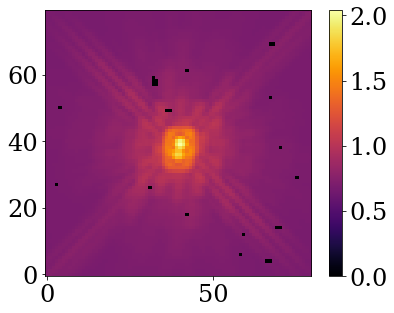

In [57]:
plt.imshow(samples['psf'][0].reshape((wid,wid))**0.125)
plt.colorbar()

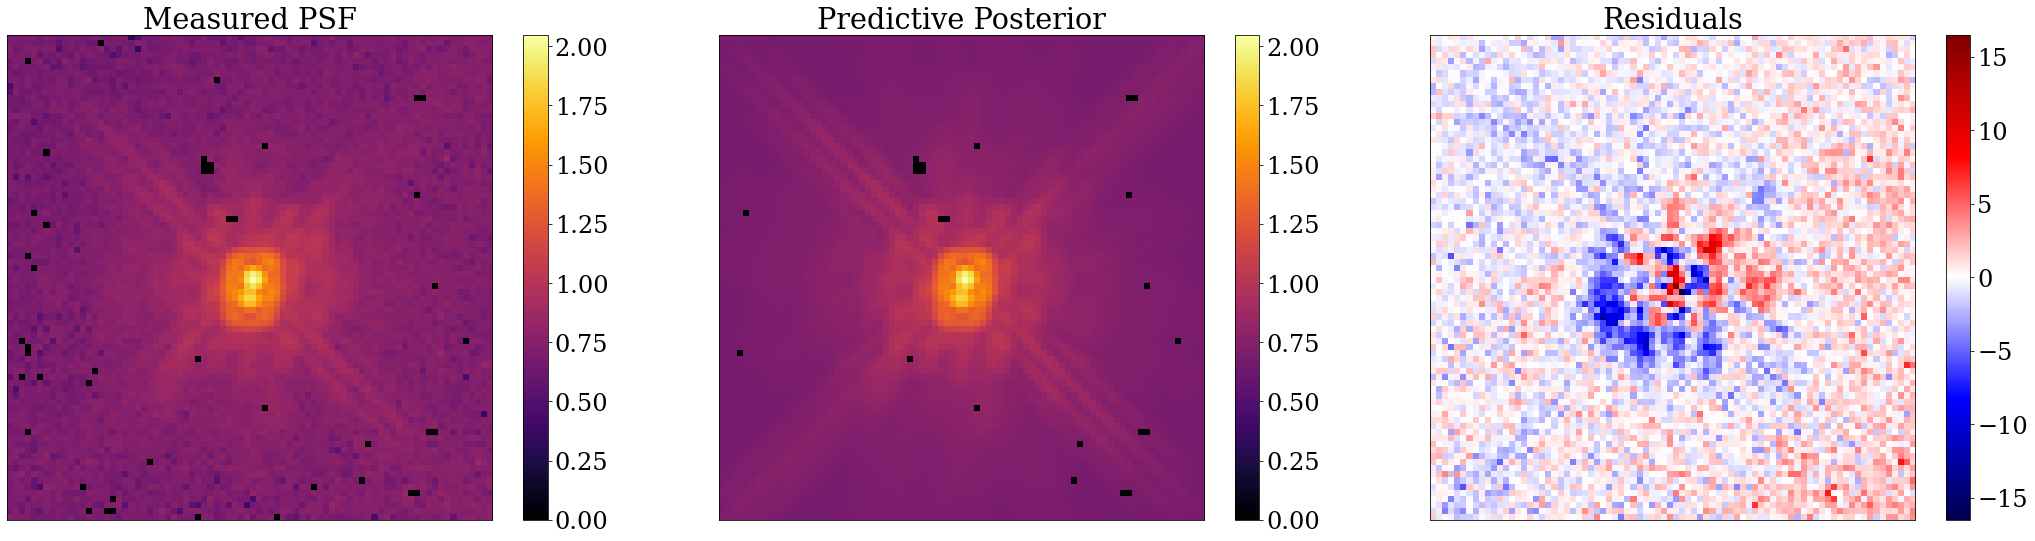

In [63]:
fig, axs = plt.subplots(1,3, figsize=(30,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

posterior = samples['psf'][0].reshape((wid,wid))

cropped_frame = exp.data**0.125

posterior_frame = posterior**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(posterior_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])


tl=axs[1].imshow(posterior_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])



resid = (exp.data - posterior)/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[2].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[2])

axs[0].set_title("Measured PSF")
axs[1].set_title("Predictive Posterior")
axs[2].set_title("Residuals")

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#if save:
#    fig.savefig(f"{save}_{f}.png")